#### Ideal Quantum SVM - Spambase

In [1]:
# Check Qiskit, Qiskit Aer versions, Qiskit Machine Learning - Versions
import qiskit
import qiskit_aer
print(qiskit.__version__)
print("Aer:", qiskit_aer.__version__)

1.4.4
Aer: 0.17.2


In [2]:
# To ensure reproducibility of results
from qiskit_machine_learning.utils import algorithm_globals
algorithm_globals.random_seed = 12345

In [ ]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
# from imblearn.over_sampling import RandomOverSampler  # For optional balancing



In [ ]:
# Qiskit Imports
# Definine quantum kernel
# Use the FidelityQuantumKernel class 

from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

In [4]:
# --- Import Spambase Column Names ---
spambase_columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
    # finally the target label column:
    "label"
]

# --- 1. Load the Spambase Dataset ---
file_path = r'C:\Users\User\Documents\MyProjects\FYP_ResearchProject\data\spambase\spambase.data'
df = pd.read_csv(file_path, header=None, names=spambase_columns)
df.drop_duplicates(inplace=True)


In [5]:
# 3. Separate features and target
X = df.drop('label', axis=1) # Columns axis 1, Rows axis 2 - just additional info
y = df['label']

# Now got : 
# Features - X
# Target - y

In [6]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# test_size - 0.3 means 30% as test set
# random_state - ensures the random shuffling is the same every time the code runs
# if its random, the result will be different and other people might ended up getting different results as well
# stratify=y - nsures fairness when comparing classical SVM vs QSVM, especially if dataset is imbalanced (like more spam than non-spam emails).
# Look at the labels in y, calculate the percentage of each class (like 80% Class A and 20% Class B), and make sure the new training set and 
# testing set both keep that exact same 80/20 ratio.

In [7]:
# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


'''
StandardScaler - as mentioned before, it normalizes the feature to mean 0, std 1
PCA - reduces dimensionality to 4 principal components, 4 also because to match with the 4 qubit feature map
PCA - also why choose change into 4 components is to match 4 qubits of ZZFeatureMap
Also (Binary Classification) is just the classification between two classes. It does nothing to amount of qubits

Data leakage - information from test sets sneaks into the training process, makes model look better because it looks like it seen some information

Additional Info:
Why only scale and PCA the features x and not labels y
- X is because they are numerical
- So need better format of features (same range so they dont dominate), and reduce number of features to match the number of qubits

- Y are class identifiers
- Not features 
- If scaled they it destroys their meaning

Summary :
Scale + PCA → features (X)
Do not touch → labels (y)

'''

'\nStandardScaler - as mentioned before, it normalizes the feature to mean 0, std 1\nPCA - reduces dimensionality to 4 principal components, 4 also because to match with the 4 qubit feature map\nPCA - also why choose change into 4 components is to match 4 qubits of ZZFeatureMap\nAlso (Binary Classification) is just the classification between two classes. It does nothing to amount of qubits\n\nData leakage - information from test sets sneaks into the training process, makes model look better because it looks like it seen some information\n\nAdditional Info:\nWhy only scale and PCA the features x and not labels y\n- X is because they are numerical\n- So need better format of features (same range so they dont dominate), and reduce number of features to match the number of qubits\n\n- Y are class identifiers\n- Not features \n- If scaled they it destroys their meaning\n\nSummary :\nScale + PCA → features (X)\nDo not touch → labels (y)\n\n'

In [8]:
# Feature Selection (based on correlation)
THRESH = 0.9
corr_matrix_train = X_train_scaled_df.corr().abs()
upper_triangle = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))
columns_to_drop = set()
for column in upper_triangle.columns:
    high_corr_partners = upper_triangle.index[upper_triangle[column] > THRESH].tolist()
    if high_corr_partners:
        for partner in high_corr_partners:
            corr_main_vs_target = y_train.corr(X_train_scaled_df[column])
            corr_partner_vs_target = y_train.corr(X_train_scaled_df[partner])
            if abs(corr_main_vs_target) < abs(corr_partner_vs_target):
                columns_to_drop.add(column)
            else:
                columns_to_drop.add(partner)

to_drop_final = sorted(list(columns_to_drop))
X_train_selected = X_train_scaled_df.drop(columns=to_drop_final)
X_test_selected = X_test_scaled_df.drop(columns=to_drop_final)

In [9]:
# PCA
n_components = 4
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

print("--- Data Preprocessing Complete ---")
print(f"Final training data shape: {X_train_pca.shape}")
print(f"Final testing data shape: {X_test_pca.shape}\n")

--- Data Preprocessing Complete ---
Final training data shape: (2947, 4)
Final testing data shape: (1263, 4)



##### Quantum Kernel Implementation

In [10]:
# Quantum Kernel Setup - Ideal Setup
fm = ZZFeatureMap(feature_dimension=n_components, reps=2, entanglement='linear')
sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)
qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm)

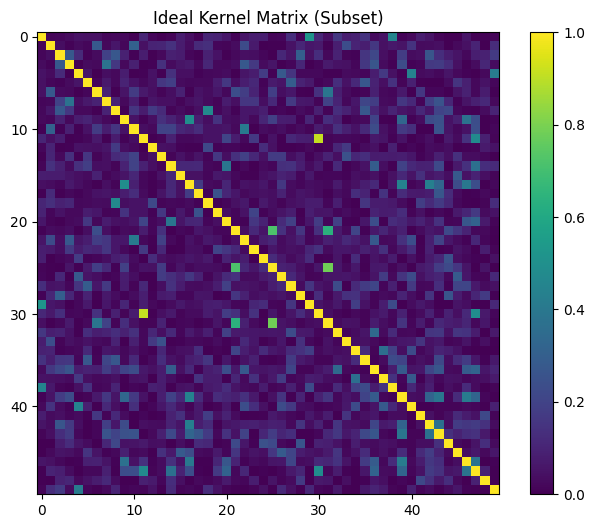

In [11]:
# Plot the ideal kernel matrix (on a subset if large)
matrix_train = qkernel.evaluate(x_vec=X_train_pca[:50])
plt.figure(figsize=(8, 6))
plt.imshow(matrix_train, cmap='viridis')
plt.title("Ideal Kernel Matrix (Subset)")
plt.colorbar()
plt.show()

qsvc_ideal = QSVC(quantum_kernel=qkernel)

In [12]:
# --- Training Ideal QSVC ---
print("--- Training Ideal QSVC (Spambase) ---\n")
start_time = time.time()

qsvc_ideal = QSVC(quantum_kernel=qkernel, C=1, class_weight='balanced')  # Tuned C, balanced weights
qsvc_ideal.fit(X_train_pca, y_train)

end_time = time.time()
print(f"QSVC training finished in {end_time - start_time:.2f} seconds.")

--- Training Ideal QSVC (Spambase) ---

QSVC training finished in 39179.18 seconds.


##### Model Evaluation

In [13]:
# Model Evaluation
y_train_pred = qsvc_ideal.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = qsvc_ideal.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

generalization_gap = abs(train_accuracy - test_accuracy)

print("\n--- Ideal QSVM Evaluation (Spambase) ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Generalization Gap: {generalization_gap:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, zero_division=0))


--- Ideal QSVM Evaluation (Spambase) ---
Training Accuracy: 0.7526
Test Accuracy:     0.6231
Generalization Gap: 0.1295

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       759
           1       0.52      0.62      0.57       504

    accuracy                           0.62      1263
   macro avg       0.62      0.62      0.62      1263
weighted avg       0.64      0.62      0.63      1263

